# NovoSparc: reconstruction of tissue geometry from single cell RNASeq data

## Reconstructing the Drosophila embryo

We adapt this [tutorial](https://github.com/rajewsky-lab/novosparc/blob/master/reconstruct_drosophila_embryo_tutorial.ipynb) that uses `novoSpaRc` to reconstruct single-cell gene expression of the Drosophila scRNA-seq dataset [Karaiskos et al., 2017, Science](https://science.sciencemag.org/content/358/6360/194). 

We differentiate between three modes of `novoSpaRc` reconstruction: 
1. Using only markers for reconstruction (using [Berkeley drosophila transcription network project ](http://bdtnp.lbl.gov/Fly-Net/bioimaging.jsp))
2. De novo, relying on cell-cell distances, and location-location distances similarity (no prior information) 
2. Integrating both assumptions


In [1]:
# imports
%matplotlib inline
import novosparc

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr

import random
random.seed(0)

In [2]:
pl_genes = ['sna', 'ken', 'eve']

## Input cells and locations descriptions to construct Tissue object
### Reading gene expression data

In [3]:
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'novosparc/datasets/drosophila_scRNAseq/'
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

number of cells: 1297
number of genes: 8924


### Preprocess data

In this example the data is already preprocessed. In the case of an unprocessed count matrix,  however, standard, or data-tailored preprocessing is recommended. Since novoSpaRc reads the dataset as a scanpy AnnData object, we use standardized preprocessing steps. For example:

In [4]:
# preprocess
# sc.pp.normalize_per_cell(dataset)
# sc.pp.log1p(dataset)

After preprocessing, it is worth observing the data size before proceeding. If cell numbers are large, we can subsample the number of cells:

In [5]:
# optional: subset cells
num_cells = 1000
sc.pp.subsample(dataset, n_obs=num_cells)

### Reduce the dimensionality of the data
To reduce the noise, capture meaningful expression distances between cells and reduce runtimes, it is advisable to decrease the dimension of gene expression. This can be done, for example, by either subsetting the gene expression matrix for highly variable genes or using PCA representation.

In [6]:
dge_rep = None # a representation of cells gene expression
sc.pp.highly_variable_genes(dataset)
is_var_gene = dataset.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])

# alternative 1: variable expressed genes representation
dge_rep = dataset.to_df()[var_genes]

# alternative 2: pca representation
sc.pp.pca(dataset)
# dge_rep = pd.DataFrame(dataset.obsm['X_pca'])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


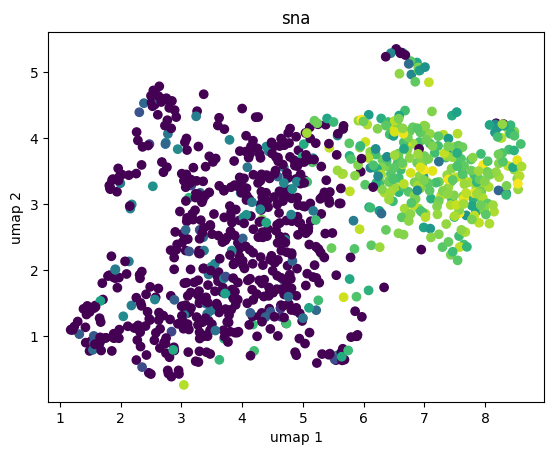

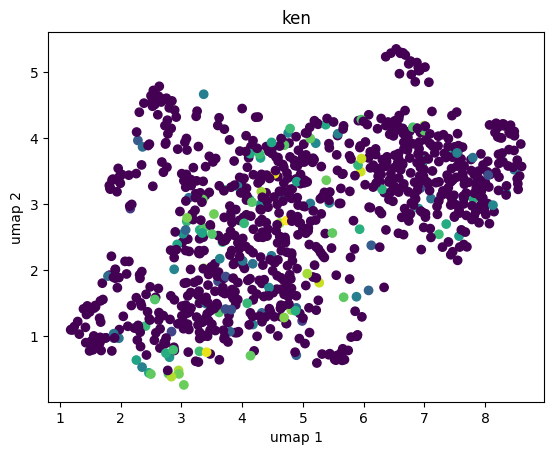

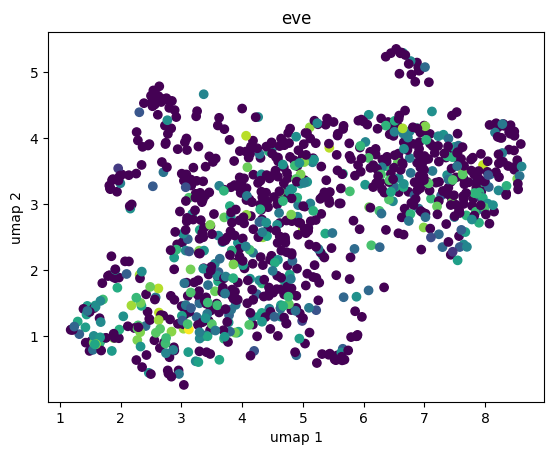

In [7]:
# exercise: explore the dataset, plot umap with color according to the intensity of each of the genes pl_genes

import umap
reducer = umap.UMAP()
dge_umap = reducer.fit_transform(dge_rep)#(dataset.to_df())

for i in range(3):
    cols = sc.get.obs_df(dataset,pl_genes[i])
    plt.scatter(dge_umap[:,0], dge_umap[:,1], c = cols)
    plt.xlabel('umap 1')
    plt.ylabel('umap 2')
    plt.title(pl_genes[i])
    plt.show()

### Create a target space

1. When using expression of marker genes ($\alpha_{linear} > 0$), target space has to correspond to the atlas' locations.

**Otherwise, there are two alternatives:**

2. Prior shape without exact locations
3. No prior knowledge of target space

#### Alternative 1: using a reference atlas
If a reference atlas is used, then the target space has to consist of its locations. 

In [8]:
atlas_dir = 'novosparc/datasets/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values

#### Alternative 2: using a prior shape without exact locations
It is possible that we know the general shape of the tissue but we are missing specific locations of the cells. In this case, the target space can be generated from a binary image:

In [9]:
tissue_path = 'novosparc/datasets/tissue_example.png'
locations_from_image = novosparc.gm.create_target_space_from_image(tissue_path)
locations_from_image = locations_from_image[np.random.choice(locations_from_image.shape[0], num_locations), :]

#### Alternative 3: no prior knowledge of the target space
novoSpaRc can create a target space by setting locations on certain basic shapes. Current supported shapes include filled circle, 2D torus projection, rectangular grid, sphere and torus. Grids can be populated with equidistant or randomly drawn points.

In [10]:
locations_circle = novosparc.gm.construct_circle(num_locations=num_locations)

Plots of the example target spaces:

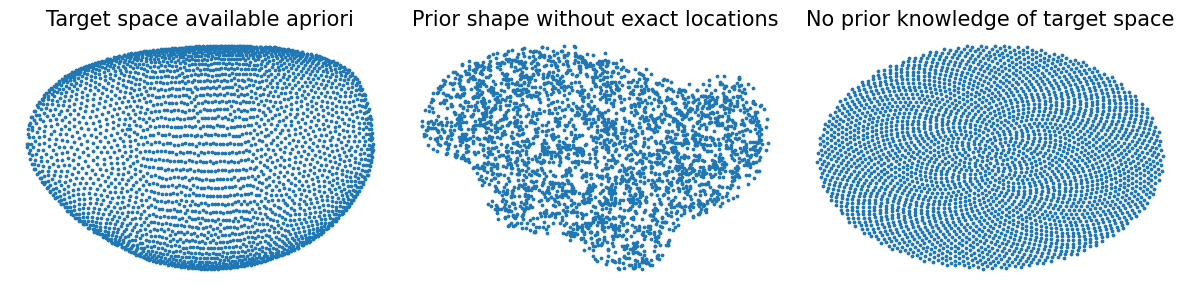

In [11]:
tit_size = 15
dpi = 100
fig, ax = plt.subplots(1,3, figsize=(12,3), dpi=dpi)

ax[0].scatter(locations_apriori[:, 0], locations_apriori[:, 1], s=3)
ax[1].scatter(locations_from_image[:, 0], locations_from_image[:, 1], s=3)
ax[2].scatter(locations_circle[:, 0], locations_circle[:, 1], s=3)

ax[0].set_title('Target space available apriori', size=tit_size)
ax[1].set_title('Prior shape without exact locations', size=tit_size)
ax[2].set_title('No prior knowledge of target space', size=tit_size)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

plt.tight_layout()
plt.show()

## Reconstruct the tissue de novo

### Construct Tissue object
So far, we constructed the input for the spatial reconstruction. Thus we next initialise a tissue object with the cell expression dataset and target space locations.

In [12]:
# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_from_image)

### Compute cost matrices
The OT framework interpolates between two assumptions, structural correspondence assumption and atlas assumption. 

With the de novo reconstruction we only need the structural correspondence assumption. For the structural correspondence (smooth) assumption we set the cells and locations the number of neighbors to use for constructing the k-Nearest Neighbors graph.

In [24]:
num_neighbors_s = num_neighbors_t = 5

# tissue.setup_reconstruction(num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# alternative: since we don't have the atlas assumption, we can also setup only the smooth costs.
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

Setting up for reconstruction ... done ( 1.46 seconds )


### Compute OT of cells to locations with a given alpha parameter

Now we can reconstruct our tissue. The `alpha_linear` parameter controls the contribution of the two branches in `novoSpaRc`: `alpha_linear=0` means that no prior information is available, while `alpha_linear=1` implies that the reconstruction will be only based on the reference marker genes provided. Here we aim for a de novo reconstruction.

In addition to setting alpha_linear, epsilon, the coefficient of the entropy can also be set. A low epsilon will result in a more definitive mapping and a higher epsilon with a more continuous one. Choosing a low epsilon often leads to numerical errors. Therefore, if this is the case, we attempt reconstruction with a greater epsilon.

In [25]:
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)

Reconstructing spatial information with 0 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


### Validate predicted expression over target space

Expression over the locations is computed and saved in tissue.sdge. This provides a genes x locations matrix describing the expression over the target space locations. 

/Users/paul/anaconda3/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


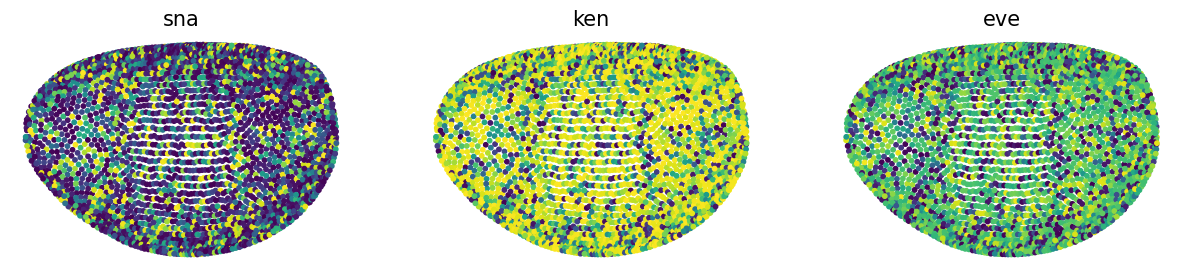

<Figure size 640x480 with 0 Axes>

In [26]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations_from_image

novosparc.pl.embedding(dataset_reconst, pl_genes)

## Reconstruct the tissue with marker genes

Available reference marker genes can assist to achieve a better reconstruction. The reference atlas we deploy here was previously analyzed to extract gene expression for the desired spatial resolution of the target space. All-in-all, the resulting atlas, e.g. atlas, rows correspond to positions of the target space locations, and columns to the atlas genes (therefore, if locations of the atlas were subset in the target space, then they need to be subset here as well).

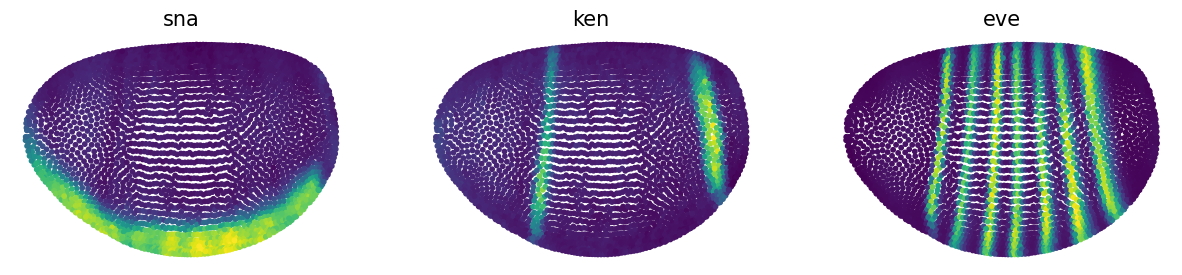

<Figure size 640x480 with 0 Axes>

In [27]:
# reading reference atlas
locations = locations_apriori
atlas_dir = 'novosparc/datasets/bdtnp/'
atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

novosparc.pl.embedding(atlas, pl_genes)

#### Testing structural correspondence assumption in atlas
If an atlas is provided, then one can test to what extent the structural correspondence assumption holds. A proxy is to look at the loc-loc expression distances vs their physical distances, hoping to see an upward-going trend. 

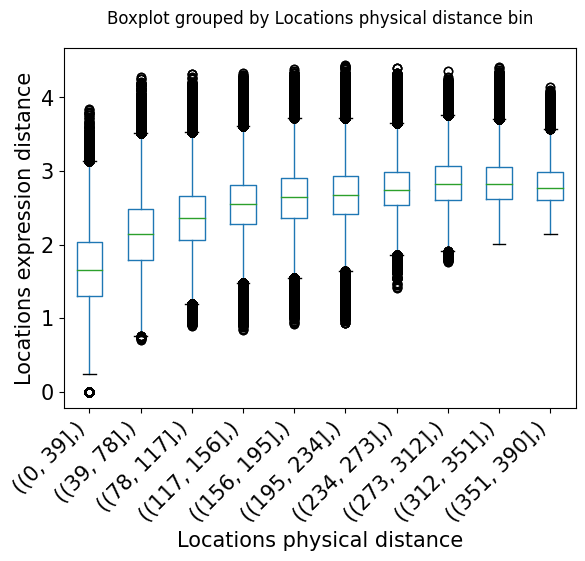

In [28]:
# Tip: visualizing loc-loc expression distances vs their physical distances
novosparc.pl.plot_exp_loc_dists(atlas.X, locations)

### Construct a Tissue object

In [29]:
# construct Tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations)

### Compute cost matrices

Since we are using atlas (linear) assumption as well, we also compute the indices of the marker genes in the expression matrix:

In [30]:
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# alternative 1: setup both assumptions 
tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                            markers_to_use=markers_to_use, 
                            num_neighbors_s=num_neighbors_s, 
                            num_neighbors_t=num_neighbors_t)

# alternative 2: handling each assumption separately
#tissue.setup_smooth_costs(dge_rep=dge_rep)
#tissue.setup_linear_cost(markers_to_use, atlas_matrix)

Setting up for reconstruction ... done ( 1.35 seconds )


### Compute OT of cells to locations with a given alpha parameter

In [28]:
# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Reconstructing spatial information with 84 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


/Users/paul/anaconda3/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning:

Transforming to str index.



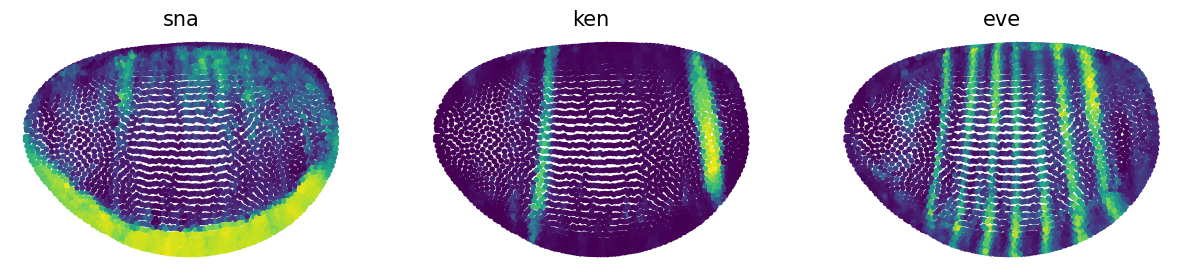

<Figure size 640x480 with 0 Axes>

In [29]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

title = ['%s' % (g) for g in pl_genes]
novosparc.pl.embedding(dataset_reconst, pl_genes, title=title)

In [75]:
# EXERCISE: compute the correlation between the predicted patterns of expression and the atlas

print(['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes])

['sna, corr=0.88', 'ken, corr=0.90', 'eve, corr=0.89']


In [83]:
# EXERCISE: Compute the prediction on a 2D or 3D Torus as target shape
